In [94]:
import sys
import requests
import re
import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt
import csv
from IPython.display import clear_output

key='ozyravmBN53mCh2imk7RmocE68QfSfjjuERYiFsqtB2j3mRog4YOoNfk4nq7t7UC'
login={'X-TBA-Auth-Key':key}

def qual_points(R,N,a=1.07):
    return np.ceil(erfinv((N-2*R+2)/(a*N))*10/erfinv(1/a)+12)
def pick_points(alliance,pick):
    if(alliance==None): return 0
    elif(pick==2): return alliance
    else: return 17-alliance
def score(rank,compnum,awards,c_rank,c_awards,chair,ei):
    return 22*(1-rank)*compnum+20*awards+22*(1-c_rank)+30*c_awards+60*chair+45*ei
def find(team,team_list):
    team='frc'+str(team)
    for i in range(len(team_list)):
        if (team_list[i][0]==team): return i
    return None
def update_progress(progress):
    barLength = 42 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), round(progress*100,3), status)
    sys.stdout.write(text)
    sys.stdout.flush()

# Regionals

In [139]:
event_name='2019tnkn'
teams_list=requests.get('https://www.thebluealliance.com/api/v3/event/'+event_name+'/teams/keys',params=login)
teams=teams_list.json()
print(len(teams))

47


In [140]:
team_scores=[]
rookies=0
update_progress(0)
for t in teams:
    team_no=int(re.findall(r'\d+',t)[0])
    if(team_no<7400):
        metrics=[[[],[],[]],[[],[],[]],[[],[],[]]]
        for y in ['2018','2017','2016']:#'2018','2017',
            event_keys=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/keys',params=login)
            r=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/statuses',params=login)
            keys=event_keys.json()
            data=r.json()
            for k in keys:
                if(data[k]!=None):
                    if(data[k]['qual']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        if((event.json()['event_type']==1)or(event.json()['event_type']==0)):#regionals and districts
                            awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    #score+=60
                                    score=score
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=20
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=5
                            metrics[2018-int(y)][0].append(score)
                        elif(event.json()['event_type']==3):#champs divisions
                            awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    #score+=110
                                    score=score
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    #score+=90
                                    score=score
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][1].append(score)
                    elif(data[k]['playoff']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        if(event.json()['event_type']==4):#einstein
                            awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                            score=5+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    #score+=110
                                    score=score
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    #score+=90
                                    score=score
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][2].append(score)
        mean=np.zeros(3)
        std=np.zeros(3)
        for i in range(3):
            if(len(metrics[0][i])+len(metrics[1][i])+len(metrics[2][i])==0):
                mean[i]=0
            else:
                mean[i]=(sum(metrics[0][i])+sum(metrics[1][i])/2+sum(metrics[2][i])/3)/(len(metrics[0][i])+len(metrics[1][i])/2+len(metrics[2][i])/3)
            if(len(metrics[0][i]+metrics[1][i]+metrics[2][i])==0):
                std[i]=0
            elif((len(metrics[0][i]+metrics[1][i]+metrics[2][i])<=3)&(i==0)):
                std[i]=13.3
            else:
                std[i]=np.std(metrics[0][i]+metrics[1][i]+metrics[2][i])
        team_scores.append([team_no,round(mean[0]-std[0],1),round(mean[1]-std[1],1),round(mean[2]-std[2],1)])
    else:
        rookies+=1
    update_progress((teams.index(t)+1)/len(teams))
if(rookies>0): team_scores.append(['Rookie',round((40/rookies+13+236/len(teams))-19.2,1),0,0])#40pts from rookie awards,13 avg ranking points,236 picking points
team_scores.sort(key=lambda score: score[1], reverse=True)

filename=event_name+'.csv'
with open(filename,'a',newline='') as csv_file:
    writer=csv.writer(csv_file)
    for i in range(len(team_scores)):
        writer.writerow(team_scores[i])
        
clear_output()
print(str(rookies)+' Rookies')
print(team_scores)#

4 Rookies
[[3140, 38.1, 11.2, 0.0], [1706, 37.4, 33.0, 0.0], [3824, 36.9, 20.9, 0.0], [3959, 33.6, 19.5, 0.0], [3489, 30.1, 31.3, 0.0], [932, 29.2, 12.0, 0.0], [6517, 25.4, 8.0, 0.0], [343, 23.7, 28.0, 0.0], [1466, 20.4, 39.0, 0.0], [4020, 18.7, 0.0, 0.0], [3490, 18.2, 10.1, 0.0], [2386, 16.8, 17.0, 0.0], [801, 16.5, 12.0, 0.0], [34, 13.9, 0.0, 0.0], [4329, 13.2, 20.0, 0.0], [1319, 13.0, 20.0, 0.0], [4576, 12.6, 13.0, 0.0], [4462, 12.2, 0.0, 0.0], [2393, 12.1, 13.0, 0.0], [3966, 11.8, 19.0, 0.0], [283, 11.2, 12.0, 0.0], [5045, 10.1, 14.0, 0.0], [4306, 9.3, 5.0, 0.0], ['Rookie', 8.8, 0, 0], [3011, 8.6, 0.0, 0.0], [5492, 8.3, 8.0, 0.0], [1758, 8.2, 0.0, 0.0], [4504, 8.1, 0.0, 0.0], [3844, 6.5, 13.0, 0.0], [5002, 6.0, 4.0, 0.0], [5022, 4.7, 0.0, 0.0], [2190, -0.8, 0.0, 0.0], [6858, -1.3, 0.0, 0.0], [6928, -1.3, 0.0, 0.0], [4630, -1.8, 0.0, 0.0], [6302, -2.0, 0.0, 0.0], [1293, -3.2, 0.0, 0.0], [2856, -3.6, 0.0, 0.0], [3821, -4.8, 0.0, 0.0], [6219, -5.1, 14.0, 0.0], [6846, -5.3, 10.0, 0.0],

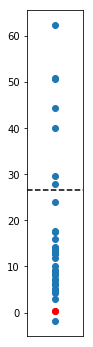

In [4]:
x=[0] *len(team_scores)
y=[x[1] for x in team_scores]

tot_score=236+85+60+45+25+15+20*5+10+9*5
for i in range(1,len(teams)+1):
    tot_score+=qual_points(i,len(teams))

fig1=plt.figure(figsize=[1,6])
ax1=plt.axes()
ax1.axes.get_xaxis().set_visible(False)
plt.axhline(y=tot_score/len(teams),c='black',linestyle='--')
plt.scatter(x,y)
plt.scatter(0,y[ind],c='red')

# Districts

In [15]:
event_name='2019fim'
teams_list=requests.get('https://www.thebluealliance.com/api/v3/district/'+event_name+'/teams/keys',params=login)
teams=teams_list.json()
print(len(teams))

549


In [18]:
#Need to think some more about rookie score, not sure it's 100% right. Also need to think about if need to consider the fact that we only get points for the first 2 events a team plays at
team_scores=[]
rookies=0
update_progress(0)
for t in teams:
    team_no=int(re.findall(r'\d+',t)[0])
    if(team_no<7400):
        metrics=[[[],[],[]],[[],[],[]],[[],[],[]]]
        for y in ['2018','2017','2016']:#'2018','2017',
            event_keys=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/keys',params=login)
            r=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/statuses',params=login)
            keys=event_keys.json()
            data=r.json()
            for k in keys:
                if(data[k]!=None):
                    if(data[k]['qual']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                        if((event.json()['event_type']==1)or(event.json()['event_type']==0)):#regionals and districts
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=60
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=20
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=5
                            metrics[2018-int(y)][0].append(score)
                        elif(event.json()['event_type']==3):#champs divisions
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=110
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    score+=90
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][1].append(score)
                    elif(data[k]['playoff']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                        if(event.json()['event_type']==4):#einstein
                            score=5+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=110
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    score+=90
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][2].append(score)
        mean=np.zeros(3)
        std=np.zeros(3)
        for i in range(3):
            if(len(metrics[0][i])+len(metrics[1][i])+len(metrics[2][i])==0):
                mean[i]=0
            else:
                mean[i]=(sum(metrics[0][i])+sum(metrics[1][i])/2+sum(metrics[2][i])/3)/(len(metrics[0][i])+len(metrics[1][i])/2+len(metrics[2][i])/3)
            if(len(metrics[0][i]+metrics[1][i]+metrics[2][i])==0):
                std[i]=0
            elif((i==0)&(len(metrics[0][i]+metrics[1][i]+metrics[2][i])<=3)):
                std[i]=13.3
            else:
                std[i]=np.std(metrics[0][i]+metrics[1][i]+metrics[2][i])
        team_scores.append([team_no,round(mean[0]-std[0],1),round(mean[1]-std[1],1),round(mean[2]-std[2],1)])
    else:
        rookies+=1
    update_progress((teams.index(t)+1)/len(teams))
if(rookies>0):
    num_events=len(requests.get('https://www.thebluealliance.com/api/v3//district/'+event_name+'/events/simple',params=login).json())
    team_scores.append(['Rookie',round((40*num_events/rookies+13+236*num_events/len(teams))-19.2,1),0,0]) #40pts from rookie awards,13 avg ranking points,236 picking points
team_scores.sort(key=lambda score: score[1], reverse=True)
if(rookies>0): ind=team_scores.index(['Rookie',round((40*num_events/rookies+13+236*num_events/len(teams))-19.2,1),0,0])+1
else: ind=int(np.floor(len(teams)/2))

filename=event_name+'.csv'
with open(filename,'a',newline='') as csv_file:
    writer=csv.writer(csv_file)
    for i in range(len(team_scores)):
        writer.writerow(team_scores[i])
        
clear_output()
print(str(ind+rookies)+': '+str(rookies)+' Rookies')
print(team_scores[0:ind])#

539: 58 Rookies
[[2767, 69.6, 57.7, 30.0], [33, 67.0, 51.4, 0.0], [3656, 66.2, 14.3, 0.0], [4003, 64.9, 47.3, 15.0], [3452, 64.5, 37.4, 15.0], [2337, 62.2, 27.7, 0.0], [494, 61.7, 47.2, 10.0], [3538, 61.3, 29.4, 5.0], [2834, 61.1, 12.7, 0.0], [1718, 57.9, 20.7, 0.0], [5505, 55.8, 12.9, 0.0], [2619, 55.7, 18.5, 0.0], [67, 54.4, 42.9, 10.0], [3641, 54.3, 42.2, 0.0], [910, 54.2, 51.6, 0.0], [4391, 54.1, 3.8, 0.0], [3357, 52.9, 36.5, 20.0], [1025, 52.3, 26.5, 0.0], [3618, 51.2, -2.3, 0.0], [3770, 51.2, 14.1, 0.0], [5114, 51.2, 26.4, 0.0], [2137, 50.6, 42.5, 10.0], [3620, 50.2, 34.3, 0.0], [2054, 49.3, 40.2, 0.0], [1918, 48.3, 32.9, 0.0], [3604, 47.6, 21.2, 0.0], [85, 47.5, 23.9, 0.0], [217, 47.3, 40.3, 8.8], [1684, 47.2, 20.5, 0.0], [1711, 45.8, 5.0, 0.0], [27, 45.5, 47.2, 30.0], [3536, 45.3, 20.8, 0.0], [5050, 45.3, 45.0, 10.0], [5460, 44.6, 18.2, 0.0], [503, 44.3, 17.4, 0.0], [302, 41.0, 18.5, 20.0], [3542, 40.9, 37.0, 0.0], [5980, 39.8, 10.8, 0.0], [1023, 39.5, 19.3, 0.0], [2474, 39.5, 

In [17]:
print(t)

frc2959


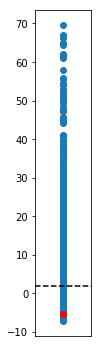

In [19]:
x=[0] *len(team_scores)
y=[x[1] for x in team_scores]

#not accurate average score for all events, need to try something like:
tot_score=(468+236+85+60+45+25+15+20*5+10+9*5)*num_events #ranking points for 36team event,pick points,elim win points,chairmans,EI,RAS,RI,robot,WFFA,others

#tot_score=236+85+60+45+25+15+20*5+10+9*5#pick points,elim win points,chairmans,EI,RAS,RI,robot,WFFA,others
#for i in range(1,len(teams)+1):
    #tot_score+=qual_points(i,len(teams))

fig1=plt.figure(figsize=[1,6])
ax1=plt.axes()
ax1.axes.get_xaxis().set_visible(False)
plt.axhline(y=tot_score/len(teams),c='black',linestyle='--')
plt.scatter(x,y)
plt.scatter(0,y[ind],c='red')

In [95]:
score_list=[]
score=0
update_progress(0)
tot_teams=len(range(1,7332))
for t in range(1,7332):
    t='frc'+str(t)
    temp_list=[]
    years=['2016','2017','2018']
    keys=[]
    data=[]
    for y in years:
        keys.append(requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/keys',params=login).json())
        d=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/statuses',params=login).json()
        if('Errors' not in data):
            data.append(d)
    off_keys=[]
    for k in keys:
        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login).json()
        if((event['event_type']==1)or(event['event_type']==0)):
            off_keys.append(k)
    if(len(off_keys)<=3):
        for k in off_keys:
            if(data[k]!=None):
                if(data[k]['qual']!=None):
                    awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                    score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                    if(data[k]['alliance']!=None):
                        score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                    for i in range(len(awards)):
                        if(awards[i]['award_type']==0):#chairman's
                            score+=60
                        if(awards[i]['award_type']==9):#engineering inspiration
                            score+=45
                        if(awards[i]['award_type']==10):#Rookie All Star
                            score+=25
                        if(awards[i]['award_type']==15):#Rookie Inspiration
                            score+=15
                        if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                            score+=20
                        if any([awards[i]['award_type'] in [22,11,27,13,14,18,30]]):#others: 14 is highest rookie seed
                            score+=5
                    temp_list.append(score)
    if(len(temp_list)<4):
        for i in temp_list:
            score_list.append(i)
mean=np.mean(score_list)
std=np.std(score_list)

print(mean,std)

26.60282574568289 18.530068691300883
